## Imports

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.ndimage import center_of_mass, shift, rotate


In [63]:
np.random.seed(42)

#### Input

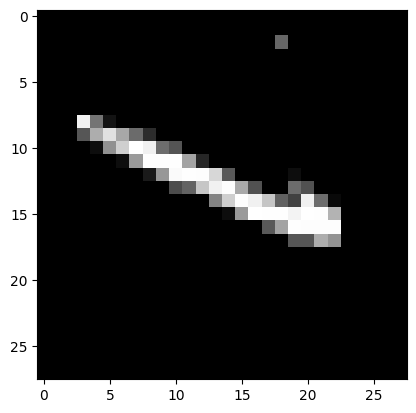

In [64]:
x_modified = np.load("Q7/X_modified.npy")
y_true = np.load("Q7/y_true.npy")
plt.imshow(x_modified[0],cmap='gray')

In [65]:
dist_vals = np.unique(y_true)
print(dist_vals)

[1 4 7 9]


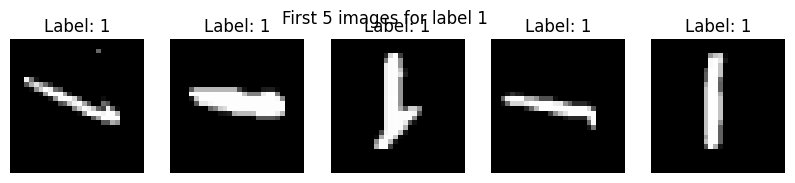

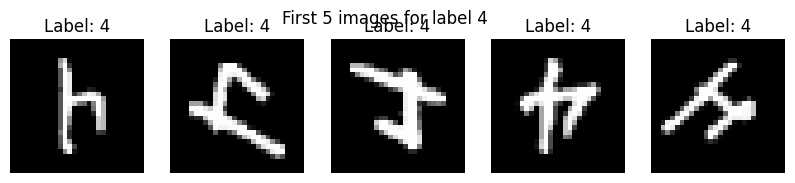

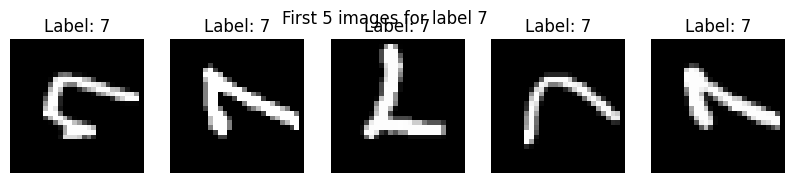

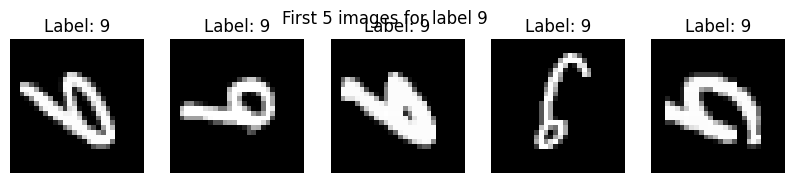

In [66]:
idxs = {}
for vals in dist_vals:
    ind_of_val = np.where(y_true==vals)[0]
    idxs[vals] = ind_of_val

for vals in dist_vals:
    imgs = idxs[vals][:5]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(imgs):
        plt.subplot(1, 5, i + 1)
        plt.imshow(x_modified[idx], cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {vals}")
    plt.suptitle(f"First 5 images for label {vals}")
    plt.show()

### Differences observed

So here the images seem to be rotated from the center and each image has a different rotation so normal pixel wise manipulation which we did when image was intact and was at center cannot be applied here

In [67]:
def get_active_pixels(img, threshold=20):
    """
    Finds the coordinates of pixels brighter than a given threshold.

    Args:
        img (np.ndarray): The input image as a 2D NumPy array.
        threshold (int): The brightness threshold (0-255). Pixels above
                         this value are considered part of the digit.

    Returns:
        tuple: A tuple (ys, xs) containing the y and x coordinates of
               the active pixels.
    """
    return np.where(img > threshold)

def get_center_of_mass(img, threshold=20):
    """
    Computes the center of mass (CoM) of the active pixels in the image.

    Args:
        img (np.ndarray): The input image.
        threshold (int): The pixel brightness threshold.

    Returns:
        tuple: A tuple (cy, cx) for the center of mass, or the image
               center if no active pixels are found.
    """
    ys, xs = get_active_pixels(img, threshold)
    if len(xs) == 0:
        # If no pixels are above the threshold, return the geometric center
        return (img.shape[0] // 2, img.shape[1] // 2)
    
    cx = xs.mean()
    cy = ys.mean()
    return cy, cx

def center_image(img, threshold=20):
    """
    Translates the image so the digit's center of mass is at the image center.

    Args:
        img (np.ndarray): The input image.
        threshold (int): The pixel brightness threshold.

    Returns:
        np.ndarray: A new image with the digit centered.
    """
    cy, cx = get_center_of_mass(img, threshold)
    h, w = img.shape
    
    # Calculate the shift required to move CoM to the center
    shift_y = int(h // 2 - cy)
    shift_x = int(w // 2 - cx)
    
    new_img = np.zeros_like(img)
    
    # Get all original pixel coordinates (not just active ones)
    ys, xs = np.nonzero(img)
    
    for y, x in zip(ys, xs):
        # Calculate new coordinates after shifting
        ny, nx = y + shift_y, x + shift_x
        
        # Copy pixel to new location if it's within bounds
        if 0 <= ny < h and 0 <= nx < w:
            new_img[ny, nx] = img[y, x]
            
    return new_img

def get_orientation(img, threshold=20):
    """
    Computes the orientation of the digit using Principal Component Analysis (PCA).
    This finds the main axis of variation among the pixel coordinates.

    Args:
        img (np.ndarray): The input image.
        threshold (int): The pixel brightness threshold.

    Returns:
        float: The angle of the main axis in radians.
    """
    ys, xs = get_active_pixels(img, threshold)
    if len(xs) < 2:  # Need at least 2 points to define an orientation
        return 0.0

    # Create a coordinate matrix [N, 2]
    coords = np.stack([xs, ys], axis=1)
    
    # Center the coordinates around their mean
    coords = coords - coords.mean(axis=0)
    
    # Compute the covariance matrix
    cov = np.cov(coords, rowvar=False)
    
    # Find eigenvectors and eigenvalues
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # The principal axis is the eigenvector with the largest eigenvalue
    main_axis = eigvecs[:, np.argmax(eigvals)]
    
    # Calculate the angle of this axis
    angle = np.arctan2(main_axis[1], main_axis[0])
    return angle

def rotate_image(img, angle):
    """
    Rotates an image around its center using an inverse mapping with
    nearest-neighbor interpolation.

    Args:
        img (np.ndarray): The image to rotate.
        angle (float): The rotation angle in radians.

    Returns:
        np.ndarray: The rotated image.
    """
    h, w = img.shape
    cy, cx = h // 2, w // 2
    
    new_img = np.zeros_like(img)
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    
    # Iterate over each pixel in the *destination* image
    for y_dest in range(h):
        for x_dest in range(w):
            # Coordinates relative to the center
            yy = y_dest - cy
            xx = x_dest - cx
            
            # Apply inverse rotation to find the corresponding source pixel
            x_src = cos_a * xx + sin_a * yy + cx
            y_src = -sin_a * xx + cos_a * yy + cy
            
            # Round to the nearest source pixel (nearest-neighbor)
            x_src, y_src = int(round(x_src)), int(round(y_src))
            
            # If the source pixel is within bounds, copy its value
            if 0 <= x_src < w and 0 <= y_src < h:
                new_img[y_dest, x_dest] = img[y_src, x_src]
                
    return new_img

def normalize_digit(img, threshold=20):
    """
    The full normalization pipeline for a single digit image.
    1. Centers the digit based on its center of mass.
    2. Rotates the digit so its principal axis is vertical.
    3. Checks the vertical skewness of the digit. If the "tail" points up,
       flips it 180 degrees to ensure it is upright.
    4. Re-centers the image after all rotations.

    Args:
        img (np.ndarray): The input 28x28 digit image.
        threshold (int): The brightness threshold to identify the digit.

    Returns:
        np.ndarray: The fully normalized digit image.
    """
    # Step 1: Center the image
    centered_img = center_image(img, threshold)
    
    # Step 2: Get the orientation angle
    angle = get_orientation(centered_img, threshold)
    
    # Step 3: Rotate the image to make the main stroke vertical
    # We want to rotate by an angle that makes the current angle point to pi/2 (90 degrees)
    angle_correction = -(angle - np.pi / 2)
    rotated_img = rotate_image(centered_img, angle_correction)
    
    # Step 4: Ensure the digit is upright using vertical skewness.
    # A positive skew means the tail is at the bottom (like '7' or '9').
    # A negative skew means the tail is at the top (like '6' or an upside-down '9').
    ys, _ = get_active_pixels(rotated_img, threshold)
    
    if len(ys) > 2: # Need a few points to calculate skew
        # Center the y-coordinates around their mean
        y_centered = ys - ys.mean()
        
        # The sign of the third moment gives the direction of the skew.
        # We only need to check the sign, not the full standardized skewness.
        third_moment = np.mean(y_centered ** 3)
        
        # If skew is negative, the tail points up. Flip it 180 degrees.
        if third_moment < 0:
            rotated_img = rotate_image(rotated_img, np.pi)
        
    # Step 5: Re-center the final image as rotation can cause small shifts
    final_img = center_image(rotated_img, threshold)
    
    return final_img

### Transformation Idea - 

Here the transformation idea is to first get the center of mass (or u may say center) of non black pixels and then translate that center to the image center.

Whatever distance changes applied to center will be applied to all the non black pixels.


After which the digits here are 1,4,7,9 so each has one vertical axis (like this | ) as the main white axis can be said as that this will be where the PCA might contribute the most so one way here was to rotate the image so that the line with maximum white pixels will become straight. To get this line PCA approach is applied to get the line and then we get the angle of the white line with the horizontal and then rotate the image by that angle to make the digit image vertical.

Finally to align correctly we are checking the third moment that is the distnace from the middle of the com  ^3 and if it comes negative then we are flipping the image horizontally.

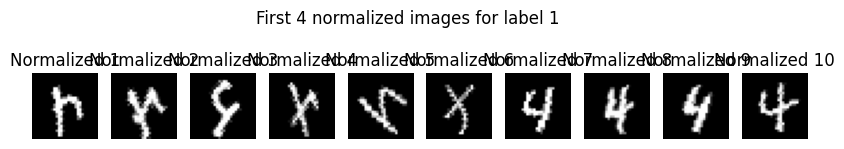

In [68]:
imgs_test = idxs[4][-10:]
final_imgs = []
for idx in imgs_test:
    final_imgs.append(normalize_digit(x_modified[idx]))
plt.figure(figsize=(10, 2))
for i, img in enumerate(final_imgs):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Normalized {i+1}")
plt.suptitle("First 4 normalized images for label 1")
plt.show()

In [69]:
class K_Means_Clustering:
    def __init__(self,df : pd.DataFrame, k : int):
        self.df = df
        self.k = k
        self.centroids = None
        self.clusters = None
    
    def fit(self):
        curr_df = self.df.copy()
        # curr_df = curr_df.drop(columns=['CustomerID','Genre'])
        # print(f"curr_df columns : {curr_df.columns}")
        self.centroids =  curr_df.sample(n=self.k,random_state=42).to_numpy()

        while True:
            self.clusters = {i : [] for i in range(self.k)}
            for point in curr_df.to_numpy():
                distances = np.linalg.norm(point - self.centroids, axis=1)
                ## we have some rows of centroids 
                ### now we calculate the norm of each point with each row thats why 
                ### we specify axis = 1
                cluster = np.argmin(distances)
                self.clusters[cluster].append(point)
            new_centroids = np.array([np.mean(self.clusters[i], axis=0) for i in range(self.k)])
            if np.allclose(new_centroids, self.centroids):
                break
            self.centroids = new_centroids

    
    def predict(self):
        # Returns the cluster index for each point in the original DataFrame order
        curr_df = self.df.copy()
        labels = []
        for point in curr_df.to_numpy():
            distances = np.linalg.norm(point - self.centroids, axis=1)
            cluster = np.argmin(distances)
            labels.append(cluster)
        return np.array(labels)
    
    def get_cost(self):
        cost = 0
        for i in range(self.k):
            for point in self.clusters[i]:
                cost += np.linalg.norm(point - self.centroids[i])**2
        return cost

In [70]:
imgs_origs_df = pd.DataFrame([img.flatten() for img in x_modified])
print(f"imgs_origs_df shape : {imgs_origs_df.shape}")

imgs_origs_df shape : (1000, 784)


In [71]:
K_means_obj  = K_Means_Clustering(imgs_origs_df, k=4)
K_means_obj.fit()
final_preds = K_means_obj.predict()
print(f"final_preds shape : {final_preds.shape}")

final_preds shape : (1000,)


In [72]:
### now we will assign the cluster label to the majority of the actual label 
mapping = {}
for cluster in range(4):
    indices = np.where(final_preds == cluster)[0]
    true_labels = y_true[indices]
    if len(true_labels) == 0:
        continue
    majority_label = np.bincount(true_labels).argmax()
    mapping[cluster] = majority_label
print("Cluster to label mapping:", mapping)


Cluster to label mapping: {0: 7, 1: 1, 2: 7, 3: 4}


In [73]:
#calculate accuracy 
correct_predictions = sum(mapping[cluster] == y_true[i] for i, cluster in enumerate(final_preds))
accuracy = correct_predictions / len(y_true)
print(f"Clustering accuracy without transformation  : {accuracy * 100:.2f}%")

Clustering accuracy without transformation: 43.60%


In [74]:
imgs_transform = [normalize_digit(img) for img in x_modified]

In [75]:
###make the image in dataframe by first converting it to 28x28 to 1 d vector of 784
df = pd.DataFrame([img.flatten() for img in imgs_transform])
print(df.shape)

(1000, 784)


In [76]:
K_means_obj = K_Means_Clustering(df,4)

In [77]:
K_means_obj.fit()

In [78]:
final_preds = K_means_obj.predict()

In [79]:
#### print count of each label in herer 
unique, counts = np.unique(final_preds, return_counts=True)
label_counts = dict(zip(unique, counts))
print("Cluster label counts:", label_counts)   

Cluster label counts: {0: 271, 1: 260, 2: 226, 3: 243}


In [80]:
### now we will assign the cluster label to the majority of the actual label 
mapping = {}
for cluster in range(4):
    indices = np.where(final_preds == cluster)[0]
    true_labels = y_true[indices]
    if len(true_labels) == 0:
        continue
    majority_label = np.bincount(true_labels).argmax()
    mapping[cluster] = majority_label
print("Cluster to label mapping:", mapping)


Cluster to label mapping: {0: 4, 1: 1, 2: 9, 3: 7}


In [81]:
# calculating accuracy 
correct_predictions = sum(mapping[cluster] == y_true[i] for i, cluster in enumerate(final_preds))
accuracy = correct_predictions / len(y_true)
print(f"Clustering accuracy: {accuracy * 100:.2f}%")

Clustering accuracy: 59.70%


So here the accuracy after doing this transformation is nearly 60 % which is a significant increase from the accuracy without transformation which was around 43%.

Here the methods used is Kmeans clustering and the distance metric is the normal euclidean distance.

Similarity between two images is simply the euclidean distance between the two images when they are represented as vectors (784x1).

### Why transformation improved


Earlier the images were not aligned and were at different rotations so the pixel wise distance was not giving a good measure of similarity between two images but after transformation the images are aligned and are at center so the pixel wise distance is a good measure of similarity between two images.

Reason the shape effect was lost in case of non transformed images as the images of different shapes could have pixels at same position due to rotation and shifting so as a result because of it they might have been clustered together but after transformation the shape effect is captured as the images are aligned and at center so the pixel wise distance is a good measure of similarity between two images.

A better approach which might increase the accuracy is to make the image binary however the original image features of grayscale would be lost.